### 作業目的: 透過實作加速版word2vec Skip-gram模型來更加了解高速版的word2vec

本次作業會採用Penn Tree Bank資料及，學員可以在ptb.train.txt中取得訓練文本資料。這次作業可以讓學員練習到以pytorch搭建模型與進行文本資料的前處理

PS: 建議學員使用Colab (或可以使用GPU加速的機器)來進行作業，不然訓練會訓練到天荒地老.....

### Connect to Google Drive

In [ ]:
# # Import libraries for importing files from Google drive to Colab
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # Authorize Google SDK to access Google Drive from Colab

# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [ ]:
# download = drive.CreateFile({'id': '請自行輸入自己上傳google drive檔案的連結id'})
# download.GetContentFile('ptb.train.txt')

### Import Necessary Libraries

In [1]:
import os
import re
import tqdm
import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import urllib.request
from typing import List
from collections import Counter
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
# 讀取資料

# Penn Tree Back dataset
with open("./ptb.train.txt", encoding='utf-8') as f:
    lines = f.readlines()
    
print(f"Total {len(lines)} lines")
raw_dataset = [line.split() for line in lines]

Total 42068 lines


In [3]:
# 查看前5筆
raw_dataset[:5]

[['aer',
  'banknote',
  'berlitz',
  'calloway',
  'centrust',
  'cluett',
  'fromstein',
  'gitano',
  'guterman',
  'hydro-quebec',
  'ipo',
  'kia',
  'memotec',
  'mlx',
  'nahb',
  'punts',
  'rake',
  'regatta',
  'rubens',
  'sim',
  'snack-food',
  'ssangyong',
  'swapo',
  'wachter'],
 ['pierre',
  '<unk>',
  'N',
  'years',
  'old',
  'will',
  'join',
  'the',
  'board',
  'as',
  'a',
  'nonexecutive',
  'director',
  'nov.',
  'N'],
 ['mr.',
  '<unk>',
  'is',
  'chairman',
  'of',
  '<unk>',
  'n.v.',
  'the',
  'dutch',
  'publishing',
  'group'],
 ['rudolph',
  '<unk>',
  'N',
  'years',
  'old',
  'and',
  'former',
  'chairman',
  'of',
  'consolidated',
  'gold',
  'fields',
  'plc',
  'was',
  'named',
  'a',
  'nonexecutive',
  'director',
  'of',
  'this',
  'british',
  'industrial',
  'conglomerate'],
 ['a',
  'form',
  'of',
  'asbestos',
  'once',
  'used',
  'to',
  'make',
  'kent',
  'cigarette',
  'filters',
  'has',
  'caused',
  'a',
  'high',
  'percen

In [6]:
class PreProcessor():
    '''Function to do preprocess of input corpus
    Parameters
    -----------
    corpus: str
        input corpus to be processed
    only_word: bool
        whether to filter out non-word
    min_freq: int
        minimum frequency of a word to be kept
    do_subsampling: bool
        whether to do subsampling
    '''
    
    def __init__(self, only_word: bool=False, min_freq: int=5, do_subsampling: bool=True, t: float=1e-5):
        self.only_word = only_word
        self.min_freq = min_freq
        self.do_subsampling = do_subsampling
        self.t = t
    
    def process(self, corpus: List[str]):
        
        word_dic = set()
        counter = Counter()
        processed_sentence = []
        
        for sentence in corpus:
        
            #計算字詞頻率
            counter.update(sentence)
            processed_sentence.append(sentence)
    
        #移除頻率過小的字詞
        word_cnt = dict(filter(lambda x: x[1] > self.min_freq, counter.items()))
        
        #添加字詞到字典中
        self.word2idx = {word: idx for idx, word in enumerate(word_cnt.keys(), 0)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        
        self.word_frequency = word_cnt.copy()
        #將文本轉為ID型式與移除文本中頻率過小的文字
        self.processed_corpus = [[self.word2idx[word] for word in line if word in self.word2idx] for line in processed_sentence]
        self.total_num_words = sum([len(line) for line in self.processed_corpus])
        print(f"Before subsampling: {self.total_num_words} words")
        
        # 進行二次採樣(subsampling)
        if self.do_subsampling:
            self.processed_corpus = [[idx for idx in line if not self.subsampling(idx)] for line in self.processed_corpus]
            self.total_num_words = sum([len(line) for line in self.processed_corpus])
            counter = Counter([self.idx2word[idx] for line in self.processed_corpus for idx in line])
            word_cnt = dict(counter.items())
            self.word_frequency = word_cnt.copy()
            print(f"After subsampling: {self.total_num_words} words")
        
        self.processed_corpus = [[idx for idx in line] for line in self.processed_corpus if len(line) != 0]
        
        return self.processed_corpus, self.word2idx, self.idx2word, self.word_frequency, self.total_num_words
    
    def subsampling(self, idx):
        p = self.t / self.word_frequency[self.idx2word[idx]] * self.total_num_words
        p_w = math.sqrt(p) + p
        return random.uniform(0, 1) < p_w


# 進行資料前處理
# 這邊我們subsampling的t取1e-4
pre_processor = PreProcessor(True, 5, True, 1e-4)
corpus, word2idx, idx2word, word2freq, total_num_words = pre_processor.process(raw_dataset)

Before subsampling: 885720 words
After subsampling: 448508 words


### 定義Skip-gram使用的Dataset與collate function

In [14]:
# 客製化Dataset
class SkipGramGetAllDataset(Dataset):
    
    def __init__(self, corpus, word2freq, word2idx, idx2word, window_size, num_negatives):
        self.corpus = corpus
        self.word2freq = word2freq
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.window_size = window_size
        self.num_negatives = num_negatives
        
        self.all_targets, self.all_contexts = self._get_all_contexts_targets()
        self.all_negatives = self._get_all_negatives()
        
    def __len__(self):
        return len(self.all_targets)
    
    def __getitem__(self, idx):
        
        # hint: 這裡我們會返回 目標字詞，上下文，負採樣樣本
        return (self.all_targets[idx], self.all_contexts[idx], self.all_negatives[idx])
        
    
    def _get_all_contexts_targets(self):
        all_targets = []
        all_contexts = []
        
        for line in self.corpus:
            if len(line) < 2*self.window_size + 1:
                continue
            
            # hint: 這邊我們要創建上下文 (考慮window_size)
            ### <your code> ###
            all_contexts += line[self.window_size:-self.window_size]
            
            for index in range(self.window_size, len(line) - self.window_size):
                # hint: 創建目標字詞
                ### <your code> ###
                indices = list(range(max(0, index - self.window_size), min(len(line), index + self.window_size + 1)))
                indices.remove(index)
                all_targets.append([line[idx] for idx in indices])
                               
        return all_targets, all_contexts
                               
    
    def _get_all_negatives(self):
        
        # hint: 進行負採樣，若沒頭緒的學員可以參考實作範例
        
        cur_exists_words = list(self.word2freq.keys())
        sampling_weights = [self.word2freq[word]**0.75 for word in self.word2freq]
        population = list(range(len(sampling_weights)))
        
        all_negatives = []
        neg_candidate = []
        i = 0
        for targets in self.all_targets:
          negatives = []
          while len(negatives) < self.num_negatives:
            if i == len(neg_candidate):
              neg_candidate = random.choices(population, sampling_weights, k = int(1e5))
              neg_candidate = list(map(lambda x: self.word2idx[cur_exists_words[x]], neg_candidate))
              i = 0
            if neg_candidate[i] not in targets:
              negatives.append(neg_candidate[i])
            i += 1
          all_negatives.append(negatives)
        
        return all_negatives
    
# 客製化collate_fn
def skipgram_collate(data):
    contexts = []
    target_negative = []
    labels = []
    for target, context, negative in data:
        # hint: 將目標字詞、上下文與負採樣樣本個別打包
      target_negative += [target + negative]
      labels += [[1] * len(target) + [0] * len(negative)]
      contexts += [context]
    
    return torch.tensor(contexts), torch.tensor(target_negative), torch.tensor(labels)

### 定義Skip-gram模型

In [15]:
class SkipGram(nn.Module):
    
    def __init__(self, vocab_size, embed_size):
        super(SkipGram, self).__init__()
        
        self.in_embedding = nn.Embedding(vocab_size, embed_size)
        self.out_embedding = nn.Embedding(vocab_size, embed_size)
        
    def forward(self, contexts, targets):
        v = self.in_embedding(contexts)
        u = self.out_embedding(targets)
        
        # do dot product to get output
        pred = torch.matmul(v[:, None, :], u.permute(0, 2, 1))
        
        return pred.squeeze(dim=1)

### 訓練

In [16]:
# Define hyperparameters

use_cuda = torch.cuda.is_available()
verbose = True
num_epochs = 100
batch_size = 512
embed_size = 100
lr = 0.01

model = SkipGram(len(word2idx), embed_size)
if use_cuda:
    model.cuda()
    
criterion = nn.BCEWithLogitsLoss(reduction = 'mean')
optimizer = optim.Adam(model.parameters(), lr = lr)
dataset = SkipGramGetAllDataset(corpus, word2freq, word2idx, idx2word, 1, 5)
loader = DataLoader(dataset, batch_size = batch_size, shuffle = True, collate_fn = skipgram_collate)

In [17]:
# Start training

lst_loss = []
model.train()
for epc in tqdm.tqdm(range(num_epochs)):
    batch_loss = 0

    for i, (contexts, target_negative, labels) in enumerate(loader, 1):
        # hint: 開始訓練前要先將optimizer的梯度歸零
        optimizer.zero_grad()
        
        if use_cuda:
            contexts = contexts.cuda()
            target_negative = target_negative.cuda()
            labels = labels.cuda()
        
        pred = model(contexts, target_negative)
        loss = criterion(pred.float(), labels.float())
        batch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if i % 500 == 0:
            print(f"Epoch: {epc + 1}/{num_epochs}, Batch: {i+1}/{len(dataset)/batch_size} Loss: {batch_loss / i:.5f}")
    
    if verbose:
        print(f"Epoch: {epc + 1}/{num_epochs}, Loss: {batch_loss / i:.5f}")
    
    lst_loss.append(batch_loss/i)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1/100, Batch: 501/714.4609375 Loss: 1.04240


  1%|          | 1/100 [00:02<04:01,  2.44s/it]

Epoch: 1/100, Loss: 0.91126
Epoch: 2/100, Batch: 501/714.4609375 Loss: 0.55398


  2%|▏         | 2/100 [00:04<03:51,  2.37s/it]

Epoch: 2/100, Loss: 0.55040
Epoch: 3/100, Batch: 501/714.4609375 Loss: 0.52762


  3%|▎         | 3/100 [00:06<03:44,  2.32s/it]

Epoch: 3/100, Loss: 0.52761
Epoch: 4/100, Batch: 501/714.4609375 Loss: 0.51848


  4%|▍         | 4/100 [00:09<03:43,  2.32s/it]

Epoch: 4/100, Loss: 0.51863
Epoch: 5/100, Batch: 501/714.4609375 Loss: 0.51293


  5%|▌         | 5/100 [00:11<03:34,  2.26s/it]

Epoch: 5/100, Loss: 0.51336
Epoch: 6/100, Batch: 501/714.4609375 Loss: 0.50903


  6%|▌         | 6/100 [00:13<03:29,  2.23s/it]

Epoch: 6/100, Loss: 0.50982
Epoch: 7/100, Batch: 501/714.4609375 Loss: 0.50617


  7%|▋         | 7/100 [00:15<03:25,  2.21s/it]

Epoch: 7/100, Loss: 0.50724
Epoch: 8/100, Batch: 501/714.4609375 Loss: 0.50456


  8%|▊         | 8/100 [00:17<03:26,  2.25s/it]

Epoch: 8/100, Loss: 0.50543
Epoch: 9/100, Batch: 501/714.4609375 Loss: 0.50298


  9%|▉         | 9/100 [00:20<03:23,  2.24s/it]

Epoch: 9/100, Loss: 0.50410
Epoch: 10/100, Batch: 501/714.4609375 Loss: 0.50221


 10%|█         | 10/100 [00:22<03:21,  2.24s/it]

Epoch: 10/100, Loss: 0.50323
Epoch: 11/100, Batch: 501/714.4609375 Loss: 0.50143


 11%|█         | 11/100 [00:24<03:15,  2.19s/it]

Epoch: 11/100, Loss: 0.50257
Epoch: 12/100, Batch: 501/714.4609375 Loss: 0.50130


 12%|█▏        | 12/100 [00:26<03:10,  2.16s/it]

Epoch: 12/100, Loss: 0.50204
Epoch: 13/100, Batch: 501/714.4609375 Loss: 0.50076


 13%|█▎        | 13/100 [00:29<03:14,  2.24s/it]

Epoch: 13/100, Loss: 0.50177
Epoch: 14/100, Batch: 501/714.4609375 Loss: 0.50039


 14%|█▍        | 14/100 [00:31<03:09,  2.20s/it]

Epoch: 14/100, Loss: 0.50158
Epoch: 15/100, Batch: 501/714.4609375 Loss: 0.50019


 15%|█▌        | 15/100 [00:33<03:04,  2.18s/it]

Epoch: 15/100, Loss: 0.50131
Epoch: 16/100, Batch: 501/714.4609375 Loss: 0.49993


 16%|█▌        | 16/100 [00:35<03:02,  2.17s/it]

Epoch: 16/100, Loss: 0.50115
Epoch: 17/100, Batch: 501/714.4609375 Loss: 0.49969


 17%|█▋        | 17/100 [00:37<03:03,  2.21s/it]

Epoch: 17/100, Loss: 0.50099
Epoch: 18/100, Batch: 501/714.4609375 Loss: 0.49982


 18%|█▊        | 18/100 [00:39<02:58,  2.18s/it]

Epoch: 18/100, Loss: 0.50096
Epoch: 19/100, Batch: 501/714.4609375 Loss: 0.49955


 19%|█▉        | 19/100 [00:42<03:00,  2.23s/it]

Epoch: 19/100, Loss: 0.50070
Epoch: 20/100, Batch: 501/714.4609375 Loss: 0.49958


 20%|██        | 20/100 [00:44<02:59,  2.25s/it]

Epoch: 20/100, Loss: 0.50072
Epoch: 21/100, Batch: 501/714.4609375 Loss: 0.49943


 21%|██        | 21/100 [00:46<02:59,  2.28s/it]

Epoch: 21/100, Loss: 0.50059
Epoch: 22/100, Batch: 501/714.4609375 Loss: 0.49983


 22%|██▏       | 22/100 [00:48<02:55,  2.25s/it]

Epoch: 22/100, Loss: 0.50053
Epoch: 23/100, Batch: 501/714.4609375 Loss: 0.49914


 23%|██▎       | 23/100 [00:51<02:50,  2.22s/it]

Epoch: 23/100, Loss: 0.50043
Epoch: 24/100, Batch: 501/714.4609375 Loss: 0.49947


 24%|██▍       | 24/100 [00:53<02:50,  2.24s/it]

Epoch: 24/100, Loss: 0.50044
Epoch: 25/100, Batch: 501/714.4609375 Loss: 0.49942


 25%|██▌       | 25/100 [00:55<02:46,  2.22s/it]

Epoch: 25/100, Loss: 0.50035
Epoch: 26/100, Batch: 501/714.4609375 Loss: 0.49913


 26%|██▌       | 26/100 [00:58<02:48,  2.28s/it]

Epoch: 26/100, Loss: 0.50031
Epoch: 27/100, Batch: 501/714.4609375 Loss: 0.49909


 27%|██▋       | 27/100 [01:00<02:44,  2.25s/it]

Epoch: 27/100, Loss: 0.50013
Epoch: 28/100, Batch: 501/714.4609375 Loss: 0.49889


 28%|██▊       | 28/100 [01:02<02:40,  2.23s/it]

Epoch: 28/100, Loss: 0.50017
Epoch: 29/100, Batch: 501/714.4609375 Loss: 0.49940


 29%|██▉       | 29/100 [01:04<02:36,  2.20s/it]

Epoch: 29/100, Loss: 0.50013
Epoch: 30/100, Batch: 501/714.4609375 Loss: 0.49902


 30%|███       | 30/100 [01:06<02:39,  2.27s/it]

Epoch: 30/100, Loss: 0.50011
Epoch: 31/100, Batch: 501/714.4609375 Loss: 0.49890


 31%|███       | 31/100 [01:09<02:34,  2.25s/it]

Epoch: 31/100, Loss: 0.49996
Epoch: 32/100, Batch: 501/714.4609375 Loss: 0.49908


 32%|███▏      | 32/100 [01:11<02:30,  2.22s/it]

Epoch: 32/100, Loss: 0.50011
Epoch: 33/100, Batch: 501/714.4609375 Loss: 0.49906


 33%|███▎      | 33/100 [01:13<02:27,  2.20s/it]

Epoch: 33/100, Loss: 0.49998
Epoch: 34/100, Batch: 501/714.4609375 Loss: 0.49959


 34%|███▍      | 34/100 [01:15<02:28,  2.26s/it]

Epoch: 34/100, Loss: 0.50001
Epoch: 35/100, Batch: 501/714.4609375 Loss: 0.49895


 35%|███▌      | 35/100 [01:17<02:24,  2.22s/it]

Epoch: 35/100, Loss: 0.49990
Epoch: 36/100, Batch: 501/714.4609375 Loss: 0.49919


 36%|███▌      | 36/100 [01:20<02:20,  2.20s/it]

Epoch: 36/100, Loss: 0.49998
Epoch: 37/100, Batch: 501/714.4609375 Loss: 0.49880


 37%|███▋      | 37/100 [01:22<02:18,  2.19s/it]

Epoch: 37/100, Loss: 0.49986
Epoch: 38/100, Batch: 501/714.4609375 Loss: 0.49899


 38%|███▊      | 38/100 [01:24<02:16,  2.20s/it]

Epoch: 38/100, Loss: 0.49982
Epoch: 39/100, Batch: 501/714.4609375 Loss: 0.49872


 39%|███▉      | 39/100 [01:26<02:16,  2.23s/it]

Epoch: 39/100, Loss: 0.49984
Epoch: 40/100, Batch: 501/714.4609375 Loss: 0.49866


 40%|████      | 40/100 [01:28<02:11,  2.20s/it]

Epoch: 40/100, Loss: 0.49980
Epoch: 41/100, Batch: 501/714.4609375 Loss: 0.49862


 41%|████      | 41/100 [01:31<02:09,  2.19s/it]

Epoch: 41/100, Loss: 0.49977
Epoch: 42/100, Batch: 501/714.4609375 Loss: 0.49882


 42%|████▏     | 42/100 [01:33<02:06,  2.18s/it]

Epoch: 42/100, Loss: 0.49989
Epoch: 43/100, Batch: 501/714.4609375 Loss: 0.49882


 43%|████▎     | 43/100 [01:35<02:06,  2.21s/it]

Epoch: 43/100, Loss: 0.49984
Epoch: 44/100, Batch: 501/714.4609375 Loss: 0.49872


 44%|████▍     | 44/100 [01:37<02:02,  2.18s/it]

Epoch: 44/100, Loss: 0.49982
Epoch: 45/100, Batch: 501/714.4609375 Loss: 0.49881


 45%|████▌     | 45/100 [01:39<02:00,  2.18s/it]

Epoch: 45/100, Loss: 0.49975
Epoch: 46/100, Batch: 501/714.4609375 Loss: 0.49857


 46%|████▌     | 46/100 [01:42<01:57,  2.18s/it]

Epoch: 46/100, Loss: 0.49973
Epoch: 47/100, Batch: 501/714.4609375 Loss: 0.49837


 47%|████▋     | 47/100 [01:44<01:58,  2.23s/it]

Epoch: 47/100, Loss: 0.49969
Epoch: 48/100, Batch: 501/714.4609375 Loss: 0.49887


 48%|████▊     | 48/100 [01:46<01:55,  2.22s/it]

Epoch: 48/100, Loss: 0.49967
Epoch: 49/100, Batch: 501/714.4609375 Loss: 0.49852


 49%|████▉     | 49/100 [01:48<01:51,  2.18s/it]

Epoch: 49/100, Loss: 0.49972
Epoch: 50/100, Batch: 501/714.4609375 Loss: 0.49844


 50%|█████     | 50/100 [01:50<01:47,  2.14s/it]

Epoch: 50/100, Loss: 0.49970
Epoch: 51/100, Batch: 501/714.4609375 Loss: 0.49866


 51%|█████     | 51/100 [01:52<01:44,  2.13s/it]

Epoch: 51/100, Loss: 0.49959
Epoch: 52/100, Batch: 501/714.4609375 Loss: 0.49863


 52%|█████▏    | 52/100 [01:55<01:44,  2.18s/it]

Epoch: 52/100, Loss: 0.49963
Epoch: 53/100, Batch: 501/714.4609375 Loss: 0.49868


 53%|█████▎    | 53/100 [01:57<01:42,  2.18s/it]

Epoch: 53/100, Loss: 0.49966
Epoch: 54/100, Batch: 501/714.4609375 Loss: 0.49859


 54%|█████▍    | 54/100 [01:59<01:39,  2.17s/it]

Epoch: 54/100, Loss: 0.49961
Epoch: 55/100, Batch: 501/714.4609375 Loss: 0.49867


 55%|█████▌    | 55/100 [02:01<01:39,  2.20s/it]

Epoch: 55/100, Loss: 0.49965
Epoch: 56/100, Batch: 501/714.4609375 Loss: 0.49898


 56%|█████▌    | 56/100 [02:04<01:38,  2.23s/it]

Epoch: 56/100, Loss: 0.49962
Epoch: 57/100, Batch: 501/714.4609375 Loss: 0.49859


 57%|█████▋    | 57/100 [02:06<01:34,  2.19s/it]

Epoch: 57/100, Loss: 0.49964
Epoch: 58/100, Batch: 501/714.4609375 Loss: 0.49861


 58%|█████▊    | 58/100 [02:08<01:32,  2.21s/it]

Epoch: 58/100, Loss: 0.49963
Epoch: 59/100, Batch: 501/714.4609375 Loss: 0.49853


 59%|█████▉    | 59/100 [02:10<01:30,  2.20s/it]

Epoch: 59/100, Loss: 0.49955
Epoch: 60/100, Batch: 501/714.4609375 Loss: 0.49862


 60%|██████    | 60/100 [02:12<01:27,  2.20s/it]

Epoch: 60/100, Loss: 0.49963
Epoch: 61/100, Batch: 501/714.4609375 Loss: 0.49861


 61%|██████    | 61/100 [02:15<01:27,  2.25s/it]

Epoch: 61/100, Loss: 0.49953
Epoch: 62/100, Batch: 501/714.4609375 Loss: 0.49825


 62%|██████▏   | 62/100 [02:17<01:25,  2.26s/it]

Epoch: 62/100, Loss: 0.49957
Epoch: 63/100, Batch: 501/714.4609375 Loss: 0.49860


 63%|██████▎   | 63/100 [02:19<01:21,  2.22s/it]

Epoch: 63/100, Loss: 0.49958
Epoch: 64/100, Batch: 501/714.4609375 Loss: 0.49877


 64%|██████▍   | 64/100 [02:21<01:19,  2.20s/it]

Epoch: 64/100, Loss: 0.49951
Epoch: 65/100, Batch: 501/714.4609375 Loss: 0.49826


 65%|██████▌   | 65/100 [02:24<01:18,  2.25s/it]

Epoch: 65/100, Loss: 0.49949
Epoch: 66/100, Batch: 501/714.4609375 Loss: 0.49858


 66%|██████▌   | 66/100 [02:26<01:16,  2.25s/it]

Epoch: 66/100, Loss: 0.49957
Epoch: 67/100, Batch: 501/714.4609375 Loss: 0.49855


 67%|██████▋   | 67/100 [02:28<01:13,  2.22s/it]

Epoch: 67/100, Loss: 0.49950
Epoch: 68/100, Batch: 501/714.4609375 Loss: 0.49852


 68%|██████▊   | 68/100 [02:30<01:10,  2.21s/it]

Epoch: 68/100, Loss: 0.49949
Epoch: 69/100, Batch: 501/714.4609375 Loss: 0.49855


 69%|██████▉   | 69/100 [02:32<01:09,  2.24s/it]

Epoch: 69/100, Loss: 0.49946
Epoch: 70/100, Batch: 501/714.4609375 Loss: 0.49820


 70%|███████   | 70/100 [02:35<01:06,  2.21s/it]

Epoch: 70/100, Loss: 0.49943
Epoch: 71/100, Batch: 501/714.4609375 Loss: 0.49841


 71%|███████   | 71/100 [02:37<01:03,  2.19s/it]

Epoch: 71/100, Loss: 0.49954
Epoch: 72/100, Batch: 501/714.4609375 Loss: 0.49858


 72%|███████▏  | 72/100 [02:39<01:01,  2.19s/it]

Epoch: 72/100, Loss: 0.49946
Epoch: 73/100, Batch: 501/714.4609375 Loss: 0.49844


 73%|███████▎  | 73/100 [02:41<00:58,  2.16s/it]

Epoch: 73/100, Loss: 0.49946
Epoch: 74/100, Batch: 501/714.4609375 Loss: 0.49818


 74%|███████▍  | 74/100 [02:43<00:56,  2.19s/it]

Epoch: 74/100, Loss: 0.49935
Epoch: 75/100, Batch: 501/714.4609375 Loss: 0.49871


 75%|███████▌  | 75/100 [02:45<00:54,  2.18s/it]

Epoch: 75/100, Loss: 0.49945
Epoch: 76/100, Batch: 501/714.4609375 Loss: 0.49823


 76%|███████▌  | 76/100 [02:48<00:51,  2.15s/it]

Epoch: 76/100, Loss: 0.49941
Epoch: 77/100, Batch: 501/714.4609375 Loss: 0.49850


 77%|███████▋  | 77/100 [02:50<00:49,  2.15s/it]

Epoch: 77/100, Loss: 0.49959
Epoch: 78/100, Batch: 501/714.4609375 Loss: 0.49815


 78%|███████▊  | 78/100 [02:52<00:48,  2.19s/it]

Epoch: 78/100, Loss: 0.49947
Epoch: 79/100, Batch: 501/714.4609375 Loss: 0.49851


 79%|███████▉  | 79/100 [02:54<00:45,  2.18s/it]

Epoch: 79/100, Loss: 0.49946
Epoch: 80/100, Batch: 501/714.4609375 Loss: 0.49808


 80%|████████  | 80/100 [02:56<00:43,  2.17s/it]

Epoch: 80/100, Loss: 0.49944
Epoch: 81/100, Batch: 501/714.4609375 Loss: 0.49874


 81%|████████  | 81/100 [02:58<00:41,  2.17s/it]

Epoch: 81/100, Loss: 0.49948
Epoch: 82/100, Batch: 501/714.4609375 Loss: 0.49822


 82%|████████▏ | 82/100 [03:01<00:40,  2.26s/it]

Epoch: 82/100, Loss: 0.49943
Epoch: 83/100, Batch: 501/714.4609375 Loss: 0.49848


 83%|████████▎ | 83/100 [03:03<00:38,  2.24s/it]

Epoch: 83/100, Loss: 0.49949
Epoch: 84/100, Batch: 501/714.4609375 Loss: 0.49829


 84%|████████▍ | 84/100 [03:05<00:35,  2.21s/it]

Epoch: 84/100, Loss: 0.49940
Epoch: 85/100, Batch: 501/714.4609375 Loss: 0.49811


 85%|████████▌ | 85/100 [03:07<00:32,  2.17s/it]

Epoch: 85/100, Loss: 0.49941
Epoch: 86/100, Batch: 501/714.4609375 Loss: 0.49836


 86%|████████▌ | 86/100 [03:09<00:30,  2.15s/it]

Epoch: 86/100, Loss: 0.49947
Epoch: 87/100, Batch: 501/714.4609375 Loss: 0.49840


 87%|████████▋ | 87/100 [03:12<00:28,  2.18s/it]

Epoch: 87/100, Loss: 0.49942
Epoch: 88/100, Batch: 501/714.4609375 Loss: 0.49850


 88%|████████▊ | 88/100 [03:14<00:26,  2.18s/it]

Epoch: 88/100, Loss: 0.49936
Epoch: 89/100, Batch: 501/714.4609375 Loss: 0.49823


 89%|████████▉ | 89/100 [03:16<00:23,  2.18s/it]

Epoch: 89/100, Loss: 0.49940
Epoch: 90/100, Batch: 501/714.4609375 Loss: 0.49816


 90%|█████████ | 90/100 [03:18<00:21,  2.18s/it]

Epoch: 90/100, Loss: 0.49943
Epoch: 91/100, Batch: 501/714.4609375 Loss: 0.49830


 91%|█████████ | 91/100 [03:21<00:20,  2.26s/it]

Epoch: 91/100, Loss: 0.49940
Epoch: 92/100, Batch: 501/714.4609375 Loss: 0.49833


 92%|█████████▏| 92/100 [03:23<00:18,  2.27s/it]

Epoch: 92/100, Loss: 0.49935
Epoch: 93/100, Batch: 501/714.4609375 Loss: 0.49849


 93%|█████████▎| 93/100 [03:25<00:15,  2.23s/it]

Epoch: 93/100, Loss: 0.49933
Epoch: 94/100, Batch: 501/714.4609375 Loss: 0.49793


 94%|█████████▍| 94/100 [03:27<00:13,  2.25s/it]

Epoch: 94/100, Loss: 0.49928
Epoch: 95/100, Batch: 501/714.4609375 Loss: 0.49843


 95%|█████████▌| 95/100 [03:30<00:11,  2.30s/it]

Epoch: 95/100, Loss: 0.49940
Epoch: 96/100, Batch: 501/714.4609375 Loss: 0.49845


 96%|█████████▌| 96/100 [03:32<00:09,  2.31s/it]

Epoch: 96/100, Loss: 0.49939
Epoch: 97/100, Batch: 501/714.4609375 Loss: 0.49840


 97%|█████████▋| 97/100 [03:34<00:06,  2.29s/it]

Epoch: 97/100, Loss: 0.49937
Epoch: 98/100, Batch: 501/714.4609375 Loss: 0.49847


 98%|█████████▊| 98/100 [03:37<00:04,  2.26s/it]

Epoch: 98/100, Loss: 0.49933
Epoch: 99/100, Batch: 501/714.4609375 Loss: 0.49849


 99%|█████████▉| 99/100 [03:39<00:02,  2.23s/it]

Epoch: 99/100, Loss: 0.49941
Epoch: 100/100, Batch: 501/714.4609375 Loss: 0.49829


100%|██████████| 100/100 [03:41<00:00,  2.22s/it]

Epoch: 100/100, Loss: 0.49948


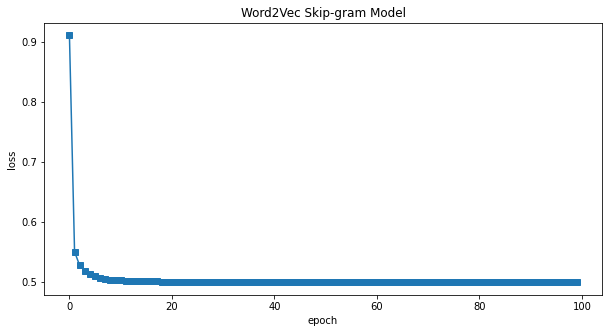

In [19]:
# visualization loss

plt.figure(figsize=(10, 5))
plt.plot(lst_loss, marker='s')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Word2Vec Skip-gram Model')
plt.show()

In [20]:
#計算字詞相似度

def get_similarity(word, top_k, model, word2idx, idx2word):
    W = (model.in_embedding.weight.data + model.out_embedding.weight.data) / 2
    idx = word2idx.get(word, None)
    
    if not idx:
        # 當出現不在字典中的字詞時，顯示Out of vocabulary error
        raise ValueError("Out of vocabulary")
    else:
        x = W[idx]
        
        # 使用cosine相似計算字詞間的相似程度
        cos = torch.matmul(W, x) / (torch.sum(W * W, dim=-1) * torch.sum(x * x) + 1e-9).sqrt()
        _, topk = torch.topk(cos, top_k+1)
        
        for i in topk[1:]:
            print(f"cosine sim={cos[int(i)]:.3f}: {idx2word[int(i)]}.")

get_similarity('love', 4, model, word2idx, idx2word)

cosine sim=0.413: equivalent.
cosine sim=0.400: fixed-price.
cosine sim=0.359: incidents.
cosine sim=0.350: bougainville.
